In [72]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torchvision import transforms
from torch.utils.data import DataLoader

In [73]:
x1 = torch.Tensor([1,2,3,4])
print(x1.shape)
x2 = torch.Tensor([4,3,2,1])
print(x2.shape)

print(torch.matmul(x1,x2))
print(torch.inner(x1,x2))
print(torch.dot(x1,x2))

torch.Size([4])
torch.Size([4])
tensor(20.)
tensor(20.)
tensor(20.)


In [24]:
# Autograd example
## Initialization
w = torch.randn(2,requires_grad=True)
x = torch.Tensor([1,2])
print(f'''
w shape : {w.shape} , x.shape : {x.shape}
requires grad , w : {w.requires_grad}, x : {x.requires_grad}
w is {w}
x is {x} 
''')


w shape : torch.Size([2]) , x.shape : torch.Size([2])
requires grad , w : True, x : False
w is tensor([ 1.2726, -0.5472], requires_grad=True)
x is tensor([1., 2.]) 



In [25]:
# Predict output
yhat = torch.inner(w,x)
# Compute loss (L2 squared Error)
loss = (x.mean() - yhat)**2
print(f"loss : {loss}")
#backpropagation
loss.backward()
# Intermediate results
print(f'''
w is {w}
x is {x}
yhat is {yhat}
gradient of w is {w.grad}
''')

loss : 1.747126579284668

w is tensor([ 1.2726, -0.5472], requires_grad=True)
x is tensor([1., 2.])
yhat is 0.17821085453033447
gradient of w is tensor([-2.6436, -5.2872])



In [22]:
# Update parameters
lr = 0.1
with torch.no_grad():
    w = w - lr*w.grad
print(f'''
w.requires_grad : {w.requires_grad}
w is {w}
w.grad is {w.grad}
''')
w.requires_grad = True


w.requires_grad : False
w is tensor([0.8136, 0.3432])
w.grad is None



In [26]:
# Update parameters
lr = 0.1
with torch.no_grad():
    w -= lr*w.grad
print(f'''
Inplace operation
w.requires_grad : {w.requires_grad}
w is {w}
w.grad is {w.grad}
''')
w.requires_grad = True


Inplace operation
w.requires_grad : True
w is tensor([ 1.5370, -0.0185], requires_grad=True)
w.grad is tensor([-2.6436, -5.2872])



# Model 관련 연습

In [37]:
# data preparation
x_seeds = np.array([(0,0),(1,0),(0,1),(1,1)],dtype=np.float32)
y_seeds = np.array([0,1,1,0])

N = 1000
idxs = np.random.randint(0,4,N)
X = x_seeds[idxs]
Y = y_seeds[idxs]
X += np.random.normal(scale=0.25,size=X.shape)

In [43]:
# Using pytorch
class pyt_shallow_nn():
    def __init__(self,num_input,num_hiddens):
        self.num_input = num_input
        self.num_hiddens = num_hiddens
        
        self.W1 = torch.randn((self.num_hiddens, self.num_input),requires_grad=True)
        self.b1 = torch.randn(self.num_hiddens, requires_grad=True)
        self.w2 = torch.randn(self.num_hiddens, requires_grad=True)
        self.b2 = torch.randn(1, requires_grad=True)
        
        self.tanh = torch.nn.Tanh()
        self.sigmoid = torch.nn.Sigmoid()
    
    def forward(self,x):
        z1 = torch.matmul(self.W1,x) + self.b1
        a1 = self.tanh(z1)
        z2 = torch.inner(self.w2,a1) + self.b2 # Vector 에서는 matmul, inner , dot 동일
        a2 = self.sigmoid(z2)
        return a2, (z1,a1,z2,a2)

In [49]:
lr = 1.0
m = len(X)
model = pyt_shallow_nn(2,4)
for epoch in range(100):
    cost = 0.0
    for x,y in zip(X,Y) :
        x_torch = torch.from_numpy(x)
        yhat,_ = model.forward(x_torch)
        loss = -y*torch.log(yhat+0.0001) - (1-y)*torch.log(1-yhat+0.0001)
        loss.backward()
        cost += loss.item()
    with torch.no_grad():
        model.W1 = model.W1 - lr*model.W1.grad/m
        model.b1 = model.b1 - lr*model.b1.grad/m
        model.w2 = model.w2 - lr*model.w2.grad/m
        model.b2 = model.b2 - lr*model.b2.grad/m
    model.W1.requires_grad = True
    model.b1.requires_grad = True
    model.w2.requires_grad = True
    model.b2.requires_grad = True
    cost /= m
    if epoch % 10 == 0:
        print(cost)
        

0.703167968571186
0.542680909126997
0.40984806953370573
0.3309936699979007
0.28382578406482933
0.2534042961001396
0.23116889131627977
0.2122963788304478
0.19556920563802124
0.1820383599512279


In [50]:
# nn.module 활용
class MyLinear(nn.Module):
    def __init__(self,in_features,out_features):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(in_features,out_features))
        self.bias = nn.Parameter(torch.randn(out_features))
    
    def forward(self, input):
        return (input @ self.weight) + self.bias

In [51]:
m = MyLinear(4,3)
sample_input = torch.randn(4)
m(sample_input)

tensor([-0.2266,  2.4446, -1.1795], grad_fn=<AddBackward0>)

In [55]:
class shallow_neural_network(nn.Module):
    def __init__(self, num_input,num_hiddens):
        super().__init__()
        self.num_input = num_input
        self.num_hiddens = num_hiddens
        
        self.layer1 = nn.Linear(self.num_input,self.num_hiddens)
        self.layer2 = nn.Linear(self.num_hiddens,1)
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self,x):
        z1 = self.layer1(x)
        a1 = self.tanh(z1)
        z2 = self.layer2(a1)
        a2 = self.sigmoid(z2)
        return a2,(z1,a1,z2,a2)
        

In [70]:
# Train
num_epoch = 100
lr = 1.0

model = shallow_neural_network(2,3)
optimizer = optim.SGD(model.parameters(),lr = lr)
loss = nn.BCELoss()

for epoch in range(num_epoch):
    optimizer.zero_grad()
    
    cost = 0.0
    for x,y in zip(X,Y):
        x_torch = torch.from_numpy(x)
        y_torch = torch.FloatTensor([y])
        
        yhat,_ = model(x_torch)
        
        loss_val = loss(yhat,y_torch)
        cost += loss_val
    cost = cost/len(X)
    cost.backward()
    optimizer.step()
    if(epoch % 10 == 0):
        print(epoch,cost)


0 tensor(0.6941, grad_fn=<DivBackward0>)
10 tensor(0.6838, grad_fn=<DivBackward0>)
20 tensor(0.6672, grad_fn=<DivBackward0>)
30 tensor(0.6431, grad_fn=<DivBackward0>)
40 tensor(0.6152, grad_fn=<DivBackward0>)
50 tensor(0.5841, grad_fn=<DivBackward0>)
60 tensor(0.5437, grad_fn=<DivBackward0>)
70 tensor(0.4817, grad_fn=<DivBackward0>)
80 tensor(0.4026, grad_fn=<DivBackward0>)
90 tensor(0.3305, grad_fn=<DivBackward0>)


# MLP

In [74]:
# Data preparation
batch_size = 16

train_data = datasets.MNIST('./datasets',train=True,download=True,transform=transforms.ToTensor())
test_data = datasets.MNIST('./datasets',train=False,download=True,transform=transforms.ToTensor())

train_loader = DataLoader(train_data, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size = batch_size)

In [77]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.in_dim = 28*28 #MNIST
        self.out_dim = 10
        
        self.fc1 = nn.Linear(self.in_dim,512)
        self.fc2 = nn.Linear(512,256)
        self.fc3 = nn.Linear(256,128)
        self.fc4 = nn.Linear(128,64)
        self.fc5 = nn.Linear(64,self.out_dim)
        
        self.relu = nn.ReLU()
        self.log_softmax = nn.LogSoftmax()
        
    def forward(self,x):
        a1 = self.relu(self.fc1(x.view(-1,self.in_dim)))
        a2 = self.relu(self.fc2(a1))
        a3 = self.relu(self.fc3(a2))
        a4 = self.relu(self.fc4(a3))
        logit = self.relu(self.fc5(a4))
        return logit

In [85]:
model = MLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(),lr = 0.01)

In [86]:
for epoch in range(20):
    running_loss = 0.0
    for i,data in enumerate(train_loader):
        inputs, labels = data
        optimizer.zero_grad()
        
        yhat = model(inputs)
        
        loss = criterion(yhat,labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if(i+1)%2000 == 0:
            print("[%d, %5d] loss : %.3f"%(epoch+1,i+1,running_loss/2000))
            running_loss = 0

print('finished Training')
            

[1,  2000] loss : 2.287
[2,  2000] loss : 1.282
[3,  2000] loss : 1.095
[4,  2000] loss : 1.036
[5,  2000] loss : 1.007
[6,  2000] loss : 0.988
[7,  2000] loss : 0.979
[8,  2000] loss : 0.768
[9,  2000] loss : 0.739
[10,  2000] loss : 0.735
[11,  2000] loss : 0.721
[12,  2000] loss : 0.716
[13,  2000] loss : 0.709
[14,  2000] loss : 0.711
[15,  2000] loss : 0.698
[16,  2000] loss : 0.694
[17,  2000] loss : 0.695
[18,  2000] loss : 0.690
[19,  2000] loss : 0.691
[20,  2000] loss : 0.696
finished Training


In [87]:
# Test
def imshow(img):
    npimg = img.numpy()
    print(f"npimg.shape : {npimg.shape}")
    np_trans = np.transpose(npimg,(1,2,0))
    print(f"np_trans.shape : {np_trans.shape}")
    plt.imshow(np_trans)
    plt.show()


npimg.shape : (3, 32, 482)
np_trans.shape : (32, 482, 3)


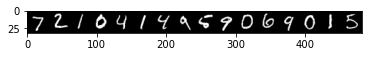

temp : 
tensor([ True,  True,  True,  True, False,  True, False, False,  True, False,
         True,  True, False,  True,  True,  True])
shape : torch.Size([16])
7855/10000
Accuracy : 0.7854999899864197


In [90]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images, nrow=batch_size))

n_predict = 0
n_correct = 0

for i,data in enumerate(test_loader) :
    inputs, labels = data
    outputs = model(inputs)
    _, predicted = torch.max(outputs,1) # indices
    
    n_predict += len(predicted)
    if(i == 0):
        temp = (labels == predicted)
        print(f"temp : \n{temp}\nshape : {temp.shape}")
    n_correct += (labels == predicted).sum()

print(f"{n_correct}/{n_predict}")
print(f"Accuracy : {n_correct/n_predict}")